<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-of-functions,-packages,-and-data" data-toc-modified-id="Load-of-functions,-packages,-and-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load of functions, packages, and data</a></span></li><li><span><a href="#Regress-backward-beta-values" data-toc-modified-id="Regress-backward-beta-values-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Regress backward beta values</a></span><ul class="toc-item"><li><span><a href="#Creating-low,-middle,-and-high-beta-values-groups-(portfolio-creation)" data-toc-modified-id="Creating-low,-middle,-and-high-beta-values-groups-(portfolio-creation)-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Creating low, middle, and high beta values groups (portfolio creation)</a></span></li><li><span><a href="#Backward-beta-summarized-alpha-and-beta-values" data-toc-modified-id="Backward-beta-summarized-alpha-and-beta-values-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Backward beta summarized alpha and beta values</a></span></li></ul></li><li><span><a href="#Step-2-in-Baker-&amp;-Wurgler" data-toc-modified-id="Step-2-in-Baker-&amp;-Wurgler-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Step 2 in Baker &amp; Wurgler</a></span><ul class="toc-item"><li><span><a href="#Second-regression" data-toc-modified-id="Second-regression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Second regression</a></span></li><li><span><a href="#Third-regression" data-toc-modified-id="Third-regression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Third regression</a></span></li></ul></li></ul></div>

## Load of functions, packages, and data

In [1]:
def geomean(data):
    
    n = data.shape[0]
    
    
    return (data+1).prod()**(1/n)-1

In [5]:
"""
Function for backward beta
"""

def market_beta(X,Y,min_win,max_win):
    """ 
    X = The independent variable which is the Market
    Y = The dependent variable which is the Stock
    min_win = minimum length of the window
    max_win = maximum length of the window
    
    It returns the alphas and the betas of
    the rolling regression
    """
    
    # all the observations
    obs = len(X)
    
    # initiate the betas with null values
    betas = np.full(obs, np.nan)
    
    # initiate the alphas with null values
    alphas = np.full(obs, np.nan)
    
    
    regressor = LinearRegression()
    for i in range(min_win,obs,1):
        if i <= max_win: #to get the expanding window
            if np.isnan(Y.to_numpy()[1 : i+1]).sum() > 0:
                pass
            else:
                regressor.fit(X.to_numpy()[1 : i+1].reshape(-1,1), Y.to_numpy()[1: i+1])
                betas[i]  = regressor.coef_[0]
                alphas[i]  = regressor.intercept_
        else: #the rolling window when periode = max window
            if np.isnan(Y.to_numpy()[i-max_win : i+1]).sum() > 0:
                pass
            else:
                regressor.fit(X.to_numpy()[i-max_win : i+1].reshape(-1,1), Y.to_numpy()[i-max_win : i+1])
                betas[i]  = regressor.coef_[0]
                alphas[i]  = regressor.intercept_
        
    return pd.DataFrame({'Alpha': alphas, 'Beta': betas})
 

In [41]:
%load_ext autoreload
%autoreload 2

"""
Load relevant packages 
"""
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from sklearn.metrics import r2_score
import pandas_datareader as pdr
import datetime
from sklearn.linear_model import LinearRegression
import seaborn as sns
import pickle
from scipy.stats import kurtosis
from scipy.stats import skew
from typing import Union, List
import math as m
from sklearn import datasets, linear_model
import statsmodels.api as sm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
"""
Set path to get save data
"""
path = "/Users/julielaustsen/Desktop/OneDrive/UNI/Speciale /Data/Eikon"
os.chdir(path) 

In [4]:
"""
Load saved dataframes and dictionareis
"""
with open('df_mkt', 'rb') as data_market_df:
    df_mkt = pickle.load(data_market_df)
    
with open('df_rf', 'rb') as data_riskfree_df:
    df_rf = pickle.load(data_riskfree_df)

with open('data_calc', 'rb') as data_dict_calc:
    data_calc = pickle.load(data_dict_calc)  
    
with open('data_calc_win', 'rb') as data_dict_win:
    data_calc_win = pickle.load(data_dict_win) 
    
with open('dict_sort', 'rb') as data_sort_list:
    dict_sort = pickle.load(data_sort_list) 

## Regress backward beta values

In [6]:
"""
Apply the backward beta function on data
"""

regress_calc = {}

for i in data_calc_win.keys():
    regress_calc[i] = market_beta(df_mkt['EUROPE IM (excess)'],data_calc_win[i].iloc[:,2], 12, 24) #set minimum and max window here
    regress_calc[i].set_index(data_calc_win[i].index)
    #regress_calc[i] = regress_calc[i].drop([0,1,2,3,4,5,6,7,8,9,10,11])

In [7]:
"""
We drop the first 12 observations because we know they wil be nan
"""
for i in data_calc_win.keys():
    regress_calc[i] = regress_calc[i].drop([0,1,2,3,4,5,6,7,8,9,10,11])

### Creating low, middle, and high beta values groups (portfolio creation)

In [8]:
"""
To have a dataframe with all the backward betas
"""
beta = pd.concat([regress_calc[i].Beta for i in list(regress_calc.keys())], axis=1)
#for i in regress_calc.keys():
beta.columns = list(regress_calc.keys())

In [9]:
"""
To create a dictionary for each portfolio group that contains a list for each timestep with the names of the banks in that group.
"""

group_one, group_two, group_three, group_four, group_five = {},{},{},{},{}
no_obs_beta = beta.shape[0]

for i in range(no_obs_beta):
        no_betas = beta.iloc[i,:].count()
        no_one, no_two, no_three, no_four = m.floor(no_betas*0.2), m.floor(no_betas*0.2), m.floor(no_betas*0.2), m.floor(no_betas*0.2) 
        no_five = no_betas - (no_one + no_two + no_three + no_four)
        group_one[i]=list(beta.iloc[i,:].sort_values()[:no_one].index)
        group_two[i]=list(beta.iloc[i,:].sort_values()[no_one:no_one+no_two].index)
        group_three[i]=list(beta.iloc[i,:].sort_values()[no_one+no_two:no_one+no_two+no_three].index)
        group_four[i]=list(beta.iloc[i,:].sort_values()[no_one+no_two+no_three:no_one+no_two+no_three+no_four].index)
        group_five[i]=list(beta.iloc[i,:].sort_values()[no_one+no_two+no_three+no_four:no_betas].index)

In [10]:
# to check how the numbers of banks develops over time
for i in range(len(list(group_three.keys()))):
    print(len(group_three[list(group_three.keys())[i]]))

27
27
27
27
27
26
26
26
26
26
26
26
26
26
26
26
26
26
27
27
27
27
27
28
28
28
28
28
28
28
28
28
28
28
28
28
28
29
29
28
29
29
29
29
29
30
30
30
30
30
30
31
31
31
31
32
32
32
32
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
31
30
30
30
30
30
30
30
30
30
30
30
31
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
30
30
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
29
30
30
30
30
29
29
29
29
28
28
28
28
28
28
28
28
27
27
27
27
27
27
27
27
27
27
27
28
27
27
27
27
27
27
28
28
28
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
27
28
27
27
27
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
28
29
29
29
29
29
29
29
29
29
29
29
28
28
28
28
28
27
27
27
27
27
27
27
27
27
27
27
27
25
25
25
25
25
25
25
25
25
25
25
25


In [11]:
"""
We create a dictionary for the 1th beta group containing a dataframe for each timestep with the banks', within
the group, alpha, beta, market value, and excess return
"""

one_group_calc = {}

for i in group_one.keys():
    df = pd.DataFrame(columns=group_one[i])
    for j in df.columns:
        s1 = regress_calc[j].iloc[i,0].copy() #alpha
        s2 = regress_calc[j].iloc[i,1].copy() #beta
        s3 = data_calc_win[j].iloc[i,0].copy() #market value
        s4 = data_calc_win[j].iloc[i,2].copy() #excess return
        df[j] = [s1,s2,s3,s4]
    one_group_calc[i] = df.T
    one_group_calc[i].columns = ['Alpha', 'Beta', 'Market value', 'Excess return']

In [12]:
"""
We create a dictionary for the 2th beta group containing a dataframe for each timestep with the banks', within
the group, alpha, beta, market value, and excess return
"""

two_group_calc = {}

for i in group_two.keys():
    df = pd.DataFrame(columns=group_two[i])
    for j in df.columns:
        s1 = regress_calc[j].iloc[i,0].copy() #alpha
        s2 = regress_calc[j].iloc[i,1].copy() #beta
        s3 = data_calc_win[j].iloc[i,0].copy() #market value
        s4 = data_calc_win[j].iloc[i,2].copy() #excess return
        df[j] = [s1,s2,s3,s4]
    two_group_calc[i] = df.T
    two_group_calc[i].columns = ['Alpha', 'Beta', 'Market value', 'Excess return']

In [13]:
"""
We create a dictionary for the 3th beta group containing a dataframe for each timestep with the banks', within
the group, alpha, beta, market value, and excess return
"""

three_group_calc = {}

for i in group_three.keys():
    df = pd.DataFrame(columns=group_three[i])
    for j in df.columns:
        s1 = regress_calc[j].iloc[i,0].copy() #alpha
        s2 = regress_calc[j].iloc[i,1].copy() #beta
        s3 = data_calc_win[j].iloc[i,0].copy() #market value
        s4 = data_calc_win[j].iloc[i,2].copy() #excess return
        df[j] = [s1,s2,s3,s4]
    three_group_calc[i] = df.T
    three_group_calc[i].columns = ['Alpha', 'Beta', 'Market value', 'Excess return']

In [14]:
"""
We create a dictionary for the 4th beta group containing a dataframe for each timestep with the banks', within
the group, alpha, beta, market value, and excess return
"""

four_group_calc = {}

for i in group_four.keys():
    df = pd.DataFrame(columns=group_four[i])
    for j in df.columns:
        s1 = regress_calc[j].iloc[i,0].copy() #alpha
        s2 = regress_calc[j].iloc[i,1].copy() #beta
        s3 = data_calc_win[j].iloc[i,0].copy() #market value
        s4 = data_calc_win[j].iloc[i,2].copy() #excess return
        df[j] = [s1,s2,s3,s4]
    four_group_calc[i] = df.T
    four_group_calc[i].columns = ['Alpha', 'Beta', 'Market value', 'Excess return']

In [15]:
"""
We create a dictionary for the 5th beta group containing a dataframe for each timestep with the banks', within
the group, alpha, beta, market value, and excess return
"""

five_group_calc = {}

for i in group_five.keys():
    df = pd.DataFrame(columns=group_five[i])
    for j in df.columns:
        s1 = regress_calc[j].iloc[i,0].copy() #alpha
        s2 = regress_calc[j].iloc[i,1].copy() #beta
        s3 = data_calc_win[j].iloc[i,0].copy() #market value
        s4 = data_calc_win[j].iloc[i,2].copy() #excess return
        df[j] = [s1,s2,s3,s4]
    five_group_calc[i] = df.T
    five_group_calc[i].columns = ['Alpha', 'Beta', 'Market value', 'Excess return']

In [16]:
"""
Assigning weights based on market value
"""

for i in one_group_calc.keys():
    one_group_calc[i]['weight'] = one_group_calc[i].iloc[:,2]/(one_group_calc[i]['Market value'].sum())

for i in two_group_calc.keys():
    two_group_calc[i]['weight'] = two_group_calc[i].iloc[:,2]/(two_group_calc[i]['Market value'].sum())
    
for i in three_group_calc.keys():
    three_group_calc[i]['weight'] = three_group_calc[i].iloc[:,2]/(three_group_calc[i]['Market value'].sum())
    
for i in four_group_calc.keys():
    four_group_calc[i]['weight'] = four_group_calc[i].iloc[:,2]/(four_group_calc[i]['Market value'].sum())
    
for i in five_group_calc.keys():
    five_group_calc[i]['weight'] = five_group_calc[i].iloc[:,2]/(five_group_calc[i]['Market value'].sum())

In [17]:
"""
Create equal-weighted and value-weighted for the 1th beta group
"""

one_val = pd.DataFrame(columns=['ew_excess_ret', 'ew_beta', 'ew_alpha', 'vw_excess_ret','vw_beta', 'vw_alpha'])

for i in one_group_calc.keys():
    one_val.loc[i,'ew_excess_ret'] = (one_group_calc[i]['Excess return']*(1/len(group_one[i]))).sum()
    one_val.loc[i,'ew_beta'] = (one_group_calc[i]['Beta']*(1/len(group_one[i]))).sum()
    one_val.loc[i,'ew_alpha'] = (one_group_calc[i]['Alpha']*(1/len(group_one[i]))).sum()
    one_val.loc[i,'vw_excess_ret'] = (one_group_calc[i]['Excess return']*one_group_calc[i]['weight']).sum()
    one_val.loc[i,'vw_beta'] = (one_group_calc[i]['Beta']*one_group_calc[i]['weight']).sum()
    one_val.loc[i,'vw_alpha'] = (one_group_calc[i]['Alpha']*one_group_calc[i]['weight']).sum()

In [18]:
"""
Create equal-weighted and value-weighted for the 2th beta group
"""

two_val = pd.DataFrame(columns=['ew_excess_ret', 'ew_beta', 'ew_alpha', 'vw_excess_ret','vw_beta', 'vw_alpha'])

for i in one_group_calc.keys():
    two_val.loc[i,'ew_excess_ret'] = (two_group_calc[i]['Excess return']*(1/len(group_two[i]))).sum()
    two_val.loc[i,'ew_beta'] = (two_group_calc[i]['Beta']*(1/len(group_two[i]))).sum()
    two_val.loc[i,'ew_alpha'] = (two_group_calc[i]['Alpha']*(1/len(group_two[i]))).sum()
    two_val.loc[i,'vw_excess_ret'] = (two_group_calc[i]['Excess return']*two_group_calc[i]['weight']).sum()
    two_val.loc[i,'vw_beta'] = (two_group_calc[i]['Beta']*two_group_calc[i]['weight']).sum()
    two_val.loc[i,'vw_alpha'] = (two_group_calc[i]['Alpha']*two_group_calc[i]['weight']).sum()

In [19]:
"""
Create equal-weighted and value-weighted for the 3th beta group
"""

three_val = pd.DataFrame(columns=['ew_excess_ret', 'ew_beta', 'ew_alpha', 'vw_excess_ret','vw_beta', 'vw_alpha'])

for i in one_group_calc.keys():
    three_val.loc[i,'ew_excess_ret'] = (three_group_calc[i]['Excess return']*(1/len(group_three[i]))).sum()
    three_val.loc[i,'ew_beta'] = (three_group_calc[i]['Beta']*(1/len(group_three[i]))).sum()
    three_val.loc[i,'ew_alpha'] = (three_group_calc[i]['Alpha']*(1/len(group_three[i]))).sum()
    three_val.loc[i,'vw_excess_ret'] = (three_group_calc[i]['Excess return']*three_group_calc[i]['weight']).sum()
    three_val.loc[i,'vw_beta'] = (three_group_calc[i]['Beta']*three_group_calc[i]['weight']).sum()
    three_val.loc[i,'vw_alpha'] = (three_group_calc[i]['Alpha']*three_group_calc[i]['weight']).sum()

In [20]:
"""
Create equal-weighted and value-weighted for the 4th beta group
"""

four_val = pd.DataFrame(columns=['ew_excess_ret', 'ew_beta', 'ew_alpha', 'vw_excess_ret','vw_beta', 'vw_alpha'])

for i in one_group_calc.keys():
    four_val.loc[i,'ew_excess_ret'] = (four_group_calc[i]['Excess return']*(1/len(group_four[i]))).sum()
    four_val.loc[i,'ew_beta'] = (four_group_calc[i]['Beta']*(1/len(group_four[i]))).sum()
    four_val.loc[i,'ew_alpha'] = (four_group_calc[i]['Alpha']*(1/len(group_four[i]))).sum()
    four_val.loc[i,'vw_excess_ret'] = (four_group_calc[i]['Excess return']*four_group_calc[i]['weight']).sum()
    four_val.loc[i,'vw_beta'] = (four_group_calc[i]['Beta']*four_group_calc[i]['weight']).sum()
    four_val.loc[i,'vw_alpha'] = (four_group_calc[i]['Alpha']*four_group_calc[i]['weight']).sum()

In [21]:
"""
Create equal-weighted and value-weighted for the 5th beta group
"""

five_val = pd.DataFrame(columns=['ew_excess_ret', 'ew_beta', 'ew_alpha', 'vw_excess_ret','vw_beta', 'vw_alpha'])

for i in one_group_calc.keys():
    five_val.loc[i,'ew_excess_ret'] = (five_group_calc[i]['Excess return']*(1/len(group_five[i]))).sum()
    five_val.loc[i,'ew_beta'] = (five_group_calc[i]['Beta']*(1/len(group_five[i]))).sum()
    five_val.loc[i,'ew_alpha'] = (five_group_calc[i]['Alpha']*(1/len(group_five[i]))).sum()
    five_val.loc[i,'vw_excess_ret'] = (five_group_calc[i]['Excess return']*five_group_calc[i]['weight']).sum()
    five_val.loc[i,'vw_beta'] = (five_group_calc[i]['Beta']*five_group_calc[i]['weight']).sum()
    five_val.loc[i,'vw_alpha'] = (five_group_calc[i]['Alpha']*five_group_calc[i]['weight']).sum()

### Backward beta summarized alpha and beta values

In [22]:
"""
Mean excess return, beta and alpha for the backward beta
"""
descriptive9 = pd.DataFrame(columns=['Mean Excess return', 'Beta', 'Alpha'])

descriptive9.loc['1th beta Equal weighted', 'Mean Excess return'] = round(geomean(one_val.iloc[:,0]),4)
descriptive9.loc['1th beta Equal weighted', 'Beta'] = round(np.mean(one_val.iloc[:,1]),4)
descriptive9.loc['1th beta Equal weighted', 'Alpha'] = round(np.mean(one_val.iloc[:,2]),4)
descriptive9.loc['1th beta Value weighted', 'Mean Excess return'] = round(geomean(one_val.iloc[:,3]),4)
descriptive9.loc['1th beta Value weighted', 'Beta'] = round(np.mean(one_val.iloc[:,4]),4)
descriptive9.loc['1th beta Value weighted', 'Alpha'] = round(np.mean(one_val.iloc[:,5]),4)
descriptive9.loc['2th beta Equal weighted', 'Mean Excess return'] = round(geomean(two_val.iloc[:,0]),4)
descriptive9.loc['2th beta Equal weighted', 'Beta'] = round(np.mean(two_val.iloc[:,1]),4)
descriptive9.loc['2th beta Equal weighted', 'Alpha'] = round(np.mean(two_val.iloc[:,2]),4)
descriptive9.loc['2th beta Value weighted', 'Mean Excess return'] = round(geomean(two_val.iloc[:,3]),4)
descriptive9.loc['2th beta Value weighted', 'Beta'] = round(np.mean(two_val.iloc[:,4]),4)
descriptive9.loc['2th beta Value weighted', 'Alpha'] = round(np.mean(two_val.iloc[:,5]),4)
descriptive9.loc['3th beta Equal weighted', 'Mean Excess return'] = round(geomean(three_val.iloc[:,0]),4)
descriptive9.loc['3th beta Equal weighted', 'Beta'] = round(np.mean(three_val.iloc[:,1]),4)
descriptive9.loc['3th beta Equal weighted', 'Alpha'] = round(np.mean(three_val.iloc[:,2]),4)
descriptive9.loc['3th beta Value weighted', 'Mean Excess return'] = round(geomean(three_val.iloc[:,3]),4)
descriptive9.loc['3th beta Value weighted', 'Beta'] = round(np.mean(three_val.iloc[:,4]),4)
descriptive9.loc['3th beta Value weighted', 'Alpha'] = round(np.mean(three_val.iloc[:,5]),4)
descriptive9.loc['4th beta Equal weighted', 'Mean Excess return'] = round(geomean(four_val.iloc[:,0]),4)
descriptive9.loc['4th beta Equal weighted', 'Beta'] = round(np.mean(four_val.iloc[:,1]),4)
descriptive9.loc['4th beta Equal weighted', 'Alpha'] = round(np.mean(four_val.iloc[:,2]),4)
descriptive9.loc['4th beta Value weighted', 'Mean Excess return'] = round(geomean(four_val.iloc[:,3]),4)
descriptive9.loc['4th beta Value weighted', 'Beta'] = round(np.mean(four_val.iloc[:,4]),4)
descriptive9.loc['4th beta Value weighted', 'Alpha'] = round(np.mean(four_val.iloc[:,5]),4)
descriptive9.loc['5th beta Equal weighted', 'Mean Excess return'] = round(geomean(five_val.iloc[:,0]),4)
descriptive9.loc['5th beta Equal weighted', 'Beta'] = round(np.mean(five_val.iloc[:,1]),4)
descriptive9.loc['5th beta Equal weighted', 'Alpha'] = round(np.mean(five_val.iloc[:,2]),4)
descriptive9.loc['5th beta Value weighted', 'Mean Excess return'] = round(geomean(five_val.iloc[:,3]),4)
descriptive9.loc['5th beta Value weighted', 'Beta'] = round(np.mean(five_val.iloc[:,4]),4)
descriptive9.loc['5th beta Value weighted', 'Alpha'] = round(np.mean(five_val.iloc[:,5]),4)

descriptive9

,Mean Excess return,Beta,Alpha
1th beta Equal weighted,-0.0015,-0.0579,-0.0
1th beta Value weighted,-0.0032,-0.0738,-0.0029
2th beta Equal weighted,-0.0019,0.306,-0.0011
2th beta Value weighted,-0.0022,0.3199,-0.0051
3th beta Equal weighted,-0.0052,0.6602,-0.0046
3th beta Value weighted,-0.0055,0.6943,-0.0054
4th beta Equal weighted,-0.0141,1.1073,-0.0099
4th beta Value weighted,-0.0103,1.1359,-0.0089
5th beta Equal weighted,-0.0328,1.9223,-0.0227
5th beta Value weighted,-0.023,1.8474,-0.015


In [23]:
"""
Mean excess return for the market
"""

mean = geomean(df_mkt['EUROPE IM (excess)'])
capm = pd.DataFrame(columns=['betas', 'excess returns'])
capm['betas']=list(range(-2,4))
capm['excess returns'] = capm['betas']* mean

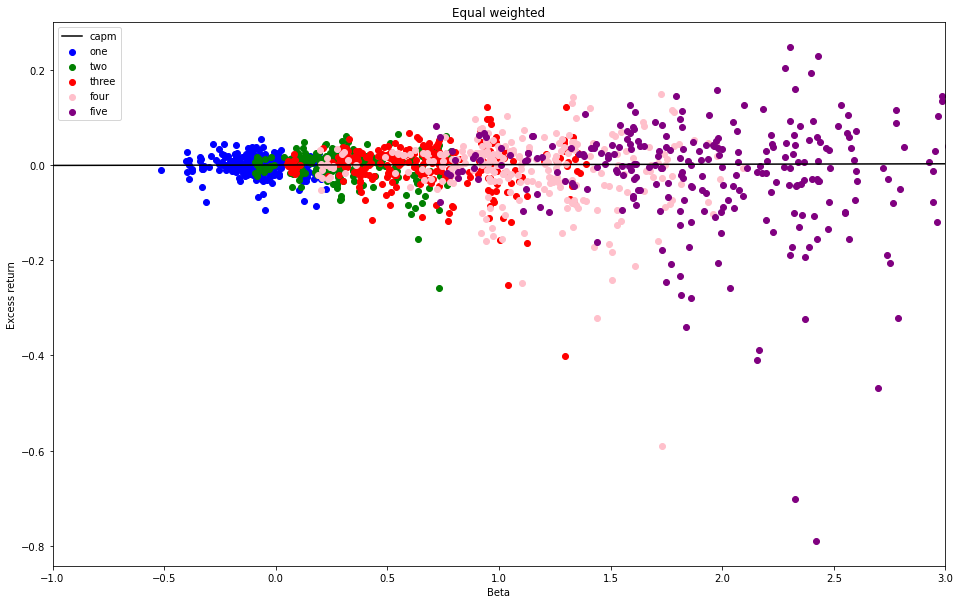

In [24]:
"""
Plot the values for the equal weighted excess returns and betas
"""

fig, ax = plt.subplots(1, 1,figsize=(16,10))
ax.scatter(one_val['ew_beta'],one_val['ew_excess_ret'], color='blue', label='one')
ax.scatter(two_val['ew_beta'],two_val['ew_excess_ret'], color='green', label='two')
ax.scatter(three_val['ew_beta'],three_val['ew_excess_ret'], color='red', label='three')
ax.scatter(four_val['ew_beta'],four_val['ew_excess_ret'], color='pink', label='four')
ax.scatter(five_val['ew_beta'],five_val['ew_excess_ret'], color='purple', label='five')
ax.plot(capm['betas'],capm['excess returns'], color='black', label='capm')
ax.set_xlim([-1,3])
ax.set_xlabel('Beta')
ax.set_ylabel('Excess return')
ax.set_title('Equal weighted')
ax.legend();

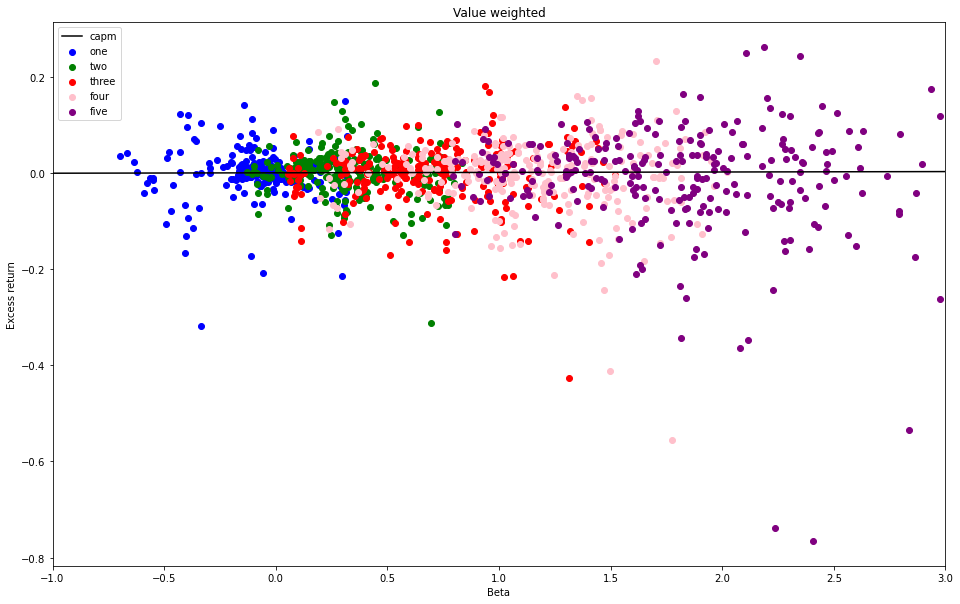

In [25]:
"""
Plot the values for the value weighted excess returns and betas
"""
fig, ax = plt.subplots(1, 1,figsize=(16,10))
ax.scatter(one_val['vw_beta'],one_val['vw_excess_ret'], color='blue', label='one')
ax.scatter(two_val['vw_beta'],two_val['vw_excess_ret'], color='green', label='two')
ax.scatter(three_val['vw_beta'],three_val['vw_excess_ret'], color='red', label='three')
ax.scatter(four_val['vw_beta'],four_val['vw_excess_ret'], color='pink', label='four')
ax.scatter(five_val['vw_beta'],five_val['vw_excess_ret'], color='purple', label='five')
ax.plot(capm['betas'],capm['excess returns'], color='black', label='capm')
ax.set_xlim([-1,3])
#ax.set_ylim([-0.1,0.1])
ax.set_xlabel('Beta')
ax.set_ylabel('Excess return')
ax.set_title('Value weighted')
ax.legend();

## Step 2 in Baker & Wurgler 
Alpha regressed on betas. The slope should be negative if there exists a low risk anomaly


In [26]:
"""
Create a dictionary that contains the 5 groups of weighted excess return, backward beta and alphas (both equal and value weighted)
"""
dict_ = {}
dict_[0] = one_val
dict_[1] = two_val
dict_[2] = three_val
dict_[3] = four_val
dict_[4] = five_val

### Second regression

In [42]:
"""
EQUAL WEIGHTED 
Based on the equal weighted excess return (backward beta groups) we estimate alpha and beta so we get a new 
timeserie with 264 alphas and betas for the 3 equal weighted groups
"""
descriptive14 = pd.DataFrame()

for i in dict_.keys():    
    Y = dict_[i]['ew_excess_ret'].astype('float64')
    X = df_mkt['EUROPE IM (excess)'].iloc[:-12].astype('float64').to_numpy().reshape(-1,1)

    lm = LinearRegression()
    lm.fit(X,Y)
    params = np.append(lm.intercept_,lm.coef_)
    predictions = lm.predict(X)

    newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
    MSE = (sum((Y-predictions)**2))/(len(newX)-len(newX.columns))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX.columns)-1))) for i in ts_b]

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,4)
    params = np.round(params,4)
    r2 = r2_score(Y,predictions)

    descriptive14.loc['Alpha', i] = params[0]
    descriptive14.loc['Alpha T-stat', i] = ts_b[0]
    descriptive14.loc['Alpha p-value', i] = p_values[0]
    descriptive14.loc['Beta', i] = params[1]
    descriptive14.loc['Beta T-stat', i] = ts_b[1]
    descriptive14.loc['Beta p-value', i] = p_values[1]
    descriptive14.loc['R-squared', i] = r2
    
descriptive14.columns=['1th beta portfolio', '2th beta portfolio', '3th beta portfolio', '4th beta portfolio', '5th beta portfolio']
descriptive14

,1th beta portfolio,2th beta portfolio,3th beta portfolio,4th beta portfolio,5th beta portfolio
Alpha,-0.001200,-0.00180,-0.004600,-0.012100,-0.024600
Alpha T-stat,-0.959000,-1.04200,-1.990000,-3.763000,-4.890000
Alpha p-value,0.338600,0.29820,0.047600,0.000200,0.000000
Beta,0.006400,0.36970,0.741800,1.161600,1.979000
Beta T-stat,0.219000,9.59200,14.279000,16.170000,17.617000
Beta p-value,0.826900,0.00000,0.000000,0.000000,0.000000
R-squared,0.000183,0.25991,0.437635,0.499498,0.542256


In [43]:
"""
VALUE WEIGHTED 
Based on the value weighted excess return (backward beta groups) we estimate alpha and beta so we get a new 
timeserie with 264 alphas and betas for the 3 value weighted groups
"""
descriptive15 = pd.DataFrame()

for i in dict_.keys():    
    Y = dict_[i]['vw_excess_ret'].astype('float64')
    X = df_mkt['EUROPE IM (excess)'].iloc[:-12].astype('float64').to_numpy().reshape(-1,1)

    lm = LinearRegression()
    lm.fit(X,Y)
    params = np.append(lm.intercept_,lm.coef_)
    predictions = lm.predict(X)

    newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
    MSE = (sum((Y-predictions)**2))/(len(newX)-len(newX.columns))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX.columns)-1))) for i in ts_b]

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,4)
    params = np.round(params,4)
    r2 = r2_score(Y,predictions)

    descriptive15.loc['Alpha', i] = params[0]
    descriptive15.loc['Alpha T-stat', i] = ts_b[0]
    descriptive15.loc['Alpha p-value', i] = p_values[0]
    descriptive15.loc['Beta', i] = params[1]
    descriptive15.loc['Beta T-stat', i] = ts_b[1]
    descriptive15.loc['Beta p-value', i] = p_values[1]
    descriptive15.loc['R-squared', i] = r2
    
descriptive15.columns=['1th beta portfolio', '2th beta portfolio', '3th beta portfolio', '4th beta portfolio', '5th beta portfolio']
descriptive15

,1th beta portfolio,2th beta portfolio,3th beta portfolio,4th beta portfolio,5th beta portfolio
Alpha,-0.001900,-0.001500,-0.004300,-0.008000,-0.015000
Alpha T-stat,-0.654000,-0.529000,-1.364000,-2.217000,-2.981000
Alpha p-value,0.513800,0.597400,0.173700,0.027500,0.003100
Beta,-0.049600,0.373300,0.771200,1.151100,1.909900
Beta T-stat,-0.750000,6.078000,10.972000,14.232000,17.025000
Beta p-value,0.454000,0.000000,0.000000,0.000000,0.000000
R-squared,0.002142,0.123583,0.314809,0.436003,0.525226


### Third regression

In [31]:
"""
We collect the ten alphas in one dataframe
"""

s1 = descriptive14.iloc[0,:].copy()
s2 = descriptive15.iloc[0,:].copy()
alphas = pd.concat([s1,s2])

In [32]:
"""
We collect the ten betas in one dataframe
"""
s1 = descriptive14.iloc[3,:].copy()
s2 = descriptive15.iloc[3,:].copy()
betas = pd.concat([s1,s2])

In [33]:
"""
We perform the third regression in order to determine whether there is a low risk anomaly
"""
Y = alphas.tolist()
X = betas.tolist() 
X2 = sm.add_constant(X)
result = sm.OLS(Y, X2).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     45.30
Date:                Wed, 04 May 2022   Prob (F-statistic):           0.000148
Time:                        09:40:57   Log-Likelihood:                 44.536
No. Observations:                  10   AIC:                            -85.07
Df Residuals:                       8   BIC:                            -84.47
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.002      0.522      0.6

/Users/julielaustsen/opt/anaconda3/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [34]:
"""
We create a datafram in order to draw the linear regression
"""
line = pd.DataFrame()
line['fik betas']=[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1, 1.25, 1.5, 1.75, 2]
line['line']=result.params[0]*10000+result.params[1]*10000*line['fik betas'] #the values is from above regression. We multiply with 1000 to get bps

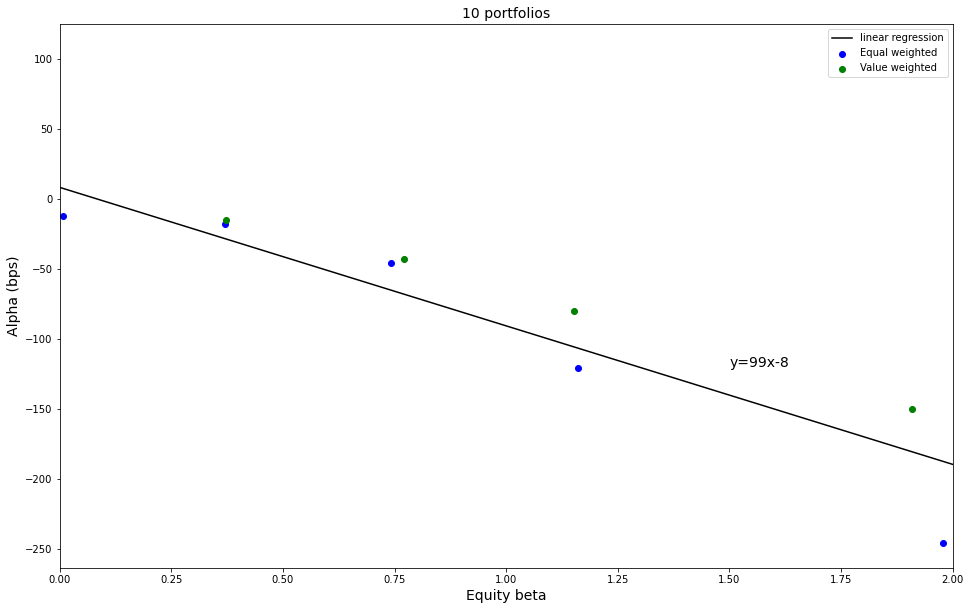

In [39]:
"""
We plot the linear regression along with the 10 pairs of alpha and beta
"""
fig, ax = plt.subplots(1, 1,figsize=(16,10))
ax.scatter(descriptive14.iloc[3,:],descriptive14.iloc[0,:]*10000, color='blue', label='Equal weighted')
ax.scatter(descriptive15.iloc[3,:],descriptive15.iloc[0,:]*10000, color='green', label='Value weighted')
ax.plot(line['fik betas'],line['line'], color='black', label='linear regression')
ax.set_xlim([-0,2])
ax.set_xlabel('Equity beta').set_fontsize(14)
ax.set_ylabel('Alpha (bps)').set_fontsize(14)
ax.text(1.5,-120,'y=99x-8').set_fontsize(14)
ax.set_title('10 portfolios').set_fontsize(14)
ax.legend();